# Simple Feature Selection Script<a class="tocSkip">
&copy; 2020 by Michael Stanley (Mike.Stanley@ieee.org)<BR>
Last revised: 25 July 2020
    
Requires presence of features.csv in the same directory as this notebook.  That file should contain "features"
extracted from raw data by a prior step in the process (ex: Feature_Extraction_Using_Pandas).

Computed feature types can include things like: min, max, mean, std, variance, skew factor, kurtosis and sum.  
The list of possible feature types is literally unlimited.
    
Techniques included in this notebook include:
* Univariate Feature Selection
* Feature Ranking Via Recursive Feature Elimination
* Feature importance with Forest of Trees
* Human-in-the-loop inspection of feature spread versus class membership.
    
See https://scikit-learn.org/stable/modules/feature_selection.html for additional details on some of the techniques shown.

# Import standard Models

In [20]:
import glob
import os
import re
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR, SVC
from sklearn.ensemble import ExtraTreesClassifier

In [21]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# Read CSV file
Read features.csv, shuffles it and then break that data into separate features and results dataFrames.  Then display the first few lines of the shuffled dataset.

The reason we shuffle the dataset is to make sure that when we subsample for training vs test, it is done in a random fashion.

In [3]:
fn = 'features.csv'
data = pd.read_csv(fn)
print('Data shape retreived from the features data file is: ', str(data.shape))

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Split out features and class membership into separate tables.
results=data['class'].astype(int)
features=data.drop(labels=['class'], axis=1)
data.head()

Data shape retreived from the features data file is:  (262, 33)


,maxAudio_max,acc_max,mag_max,gyro_max,maxAudio_min,acc_min,mag_min,gyro_min,maxAudio_skew,acc_skew,...,gyro_mean,maxAudio_std,acc_std,mag_std,gyro_std,maxAudio_var,acc_var,mag_var,gyro_var,class
0,153.0,1.04991,156.697,5.00421,124.0,0.946642,53.8269,4.10440,0.876526,-0.336700,...,4.53527,9.79796,0.041428,33.7191,0.281148,96.000,0.001716,1136.980,0.079044,1.0
1,168.0,1.05114,172.759,4.83530,106.0,0.941374,64.5163,4.04773,-0.317235,-0.639831,...,4.54742,19.93110,0.041449,40.9254,0.245930,397.250,0.001718,1674.890,0.060482,1.0
2,274.0,1.06646,181.853,4.73942,152.0,0.947862,55.8571,4.35378,0.541778,0.121536,...,4.56438,38.15430,0.045410,45.1491,0.116648,1455.750,0.002062,2038.440,0.013607,2.0
3,164.0,1.04190,174.720,4.94390,79.0,0.951017,60.3426,4.29499,-0.977913,-0.041711,...,4.59084,24.45800,0.035870,40.5260,0.238003,598.194,0.001287,1642.360,0.056646,1.0
4,237.0,1.05948,141.134,4.87497,101.0,0.934466,54.8262,4.07888,1.158520,-0.355692,...,4.50425,47.88120,0.042329,26.7623,0.231887,2292.610,0.001792,716.219,0.053771,1.0


# Subroutine for XY plots: myScatterPandas()
This utility function can create an XY plot of any two features found in the input table.  We use it here to reproduce a figure originally created by the Feature_Extraction_Using_Pandas notebook used to create our test features.csv.    You can easily compare it with the figure in the earlier notebook to convince yourself that we haven't somehow corrupted the dataset between steps.

This particular plot function works with Pandas dataframes only.  Parameters are:
* data: the pandas dataframe containing our features
* f1: string name of the 1st feature to be plotted
* f2: string name of the 2nd feature to be plotted
* C: optional second data series containing class assignments.  Used when it is not convenient to include that column in the data dataframe

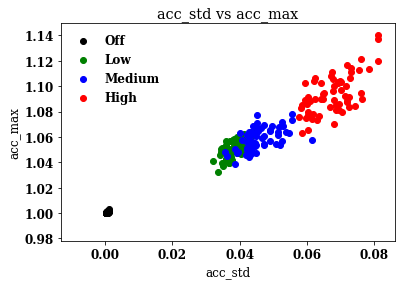

In [4]:
def myScatterPandas(data, f1, f2, C=None):
    labels=['Off', 'Low', 'Medium', 'High']
    color = ['black', 'green', 'blue', 'red']
    fig, ax = plt.subplots()
    x0 = data[f1].to_numpy()
    x1 = data[f2].to_numpy()
    if not (type(C)==pd.core.series.Series):
        C=data['class'].astype(int)
    for g in np.unique(C):
        ix = np.where(C==g)
        c=color[g]
        ax.scatter(x0[ix], x1[ix], c=c, label=labels[g])
    plt.title(f1 + ' vs ' + f2)
    plt.legend(loc='best', frameon=False, labels=['Off', 'Low', 'Medium', 'High'])
    plt.xlabel(f1)
    plt.ylabel(f2)
myScatterPandas(data, 'acc_std', 'acc_max')

# Split data into training and test sets
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(features, results, test_size=0.33, random_state=37)

# Normalize the training input data
There are several ways to normalize input data sets.  See the lecture notes for other options.  Here we subtract mean values and divide the result by the standard deviation of each feature.  Thus everything is zero-centered and scaled to 1=1 standard deviation.

scikit-Learn has standard scaler operations (https://scikit-learn.org/stable/modules/preprocessing.html).  We take advantage of pandas DataFrame operations here to do it explicitly.

In [6]:
s = X_train.std()
m = X_train.mean()
X_train = (X_train - m)/s

# Univariate Feature Selection
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

In [7]:
selector = SelectKBest(f_classif, k=2)
selector.fit(X_train, Y_train)

SelectKBest(k=2, score_func=<function f_classif at 0x000001D5D75B0CA8>)

## Look at the reduced dataset
First look at a mask of the features selected, then use that mask in the next cell to build a reduced table.

In [8]:
selector.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False])

In [9]:
reduced = features[features.columns[selector.get_support(indices=True)]]
reduced

,maxAudio_mean,acc_std
0,135.000,0.041428
1,137.667,0.041449
2,200.667,0.045410
3,130.222,0.035870
4,146.889,0.042329
...,...,...
257,201.333,0.045019
258,221.667,0.041001
259,191.000,0.054749
260,40.000,0.000886


## Plot the feature scores
to get a visual indication how well selected features stand out.

<BarContainer object of 32 artists>

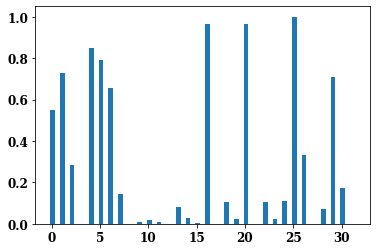

In [10]:
X_indices = np.arange(X_train.shape[-1])
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices+.1 , scores, width=.5,
        label=r'Univariate score ($-Log(p_{value})$)')

## Plot the unscaled version of selected features

True


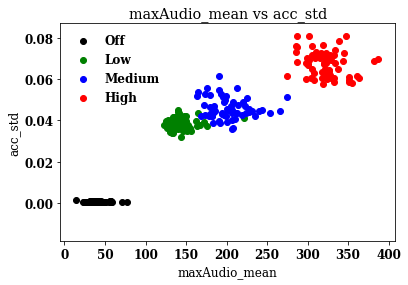

In [11]:
print(type(results)==pd.core.series.Series)
f1=reduced.columns[0]
f2=reduced.columns[1]
myScatterPandas(reduced, f1, f2, results)
# This plot is done with unscaled data

# Feature ranking via recursive feature elimination
RFECV = Recursive Feature Elimination and Cross-Validation

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html?highlight=rfecv#sklearn.feature_selection.RFECV

In [12]:
estimator = SVC(kernel='linear')
selector = RFECV(estimator, step=1, cv=4)
selector = selector.fit(X_train, Y_train)

num_selected = np.count_nonzero(selector.support_)
print(num_selected, ' features are suggested.')
selector.support_

3  features are suggested.


array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False])

In [13]:
selector.ranking_

array([11,  5, 19, 21,  1,  4, 12,  9, 14, 16, 23, 20, 18, 13, 22, 10,  2,
       30, 26,  8,  1, 28, 27,  6, 15,  3, 17, 25, 29,  1, 24,  7])

In [14]:
reduced = features[features.columns[selector.get_support(indices=True)]]
reduced

,maxAudio_min,maxAudio_mean,acc_var
0,124.0,135.000,1.716270e-03
1,106.0,137.667,1.718010e-03
2,152.0,200.667,2.062090e-03
3,79.0,130.222,1.286680e-03
4,101.0,146.889,1.791760e-03
...,...,...,...
257,149.0,201.333,2.026670e-03
258,128.0,221.667,1.681100e-03
259,117.0,191.000,2.997470e-03
260,-1.0,40.000,7.844590e-07


## Plot selected features
Because maxAudio_min and maxAudio_mean are so closely related (both being derived from microphone data), there is not a lot of unique information in the 2nd variable.  We will use the 1st and 3rd features as our selected features.  These are maxAudio_min and acc_var.

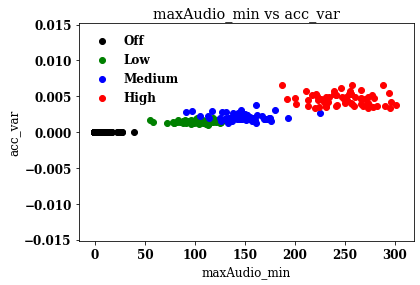

In [26]:
f1=reduced.columns[0]
f2=reduced.columns[2]
myScatterPandas(reduced, f1, f2, results)

## Plot number of features VS. cross-validation scores
This code snippet found at https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

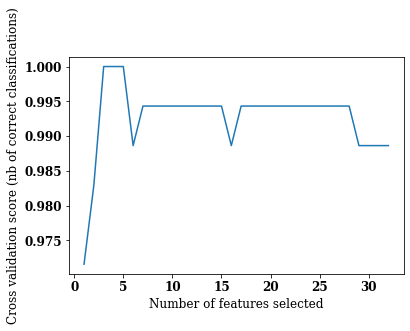

In [16]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# Feature importances with forest of trees 
This is a modified version of code that can be found at: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)

Feature ranking:
1. feature 16:	maxAudio_sum	(0.135594)
2. feature 20:	maxAudio_mean	(0.119716)
3. feature 25:	acc_std	(0.093964)
4. feature 29:	acc_var	(0.085700)
5. feature 4:	maxAudio_min	(0.084063)
6. feature 5:	acc_min	(0.080966)
7. feature 0:	maxAudio_max	(0.053198)
8. feature 2:	mag_max	(0.052102)
9. feature 1:	acc_max	(0.050277)
10. feature 6:	mag_min	(0.049080)
11. feature 26:	mag_std	(0.032659)
12. feature 30:	mag_var	(0.027149)
13. feature 27:	gyro_std	(0.014648)
14. feature 18:	mag_sum	(0.012268)
15. feature 31:	gyro_var	(0.012219)
16. feature 22:	mag_mean	(0.010400)
17. feature 19:	gyro_sum	(0.010047)
18. feature 23:	gyro_mean	(0.009306)
19. feature 7:	gyro_min	(0.008527)
20. feature 24:	maxAudio_std	(0.008251)
21. feature 3:	gyro_max	(0.006979)
22. feature 28:	maxAudio_var	(0.006732)
23. feature 21:	acc_mean	(0.004558)
24. feature 9:	acc_skew	(0.004505)
25. feature 17:	acc_sum	(0.004187)
26. feature 14:	mag_kurtosis	(0.004171)
27. feature 10:	mag_skew	(0.003682)
28. featu

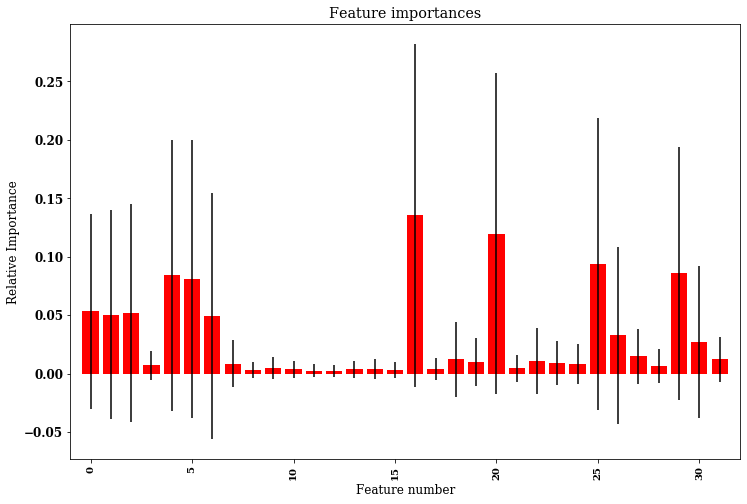

In [17]:
import matplotlib.ticker as ticker
# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, Y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d:\t%s\t(%f)" % (f + 1, indices[f], X_train.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
f, ax = plt.subplots(figsize=(12,8))
plt.title("Feature importances")
X_range = np.arange(X_train.shape[1])

plt.bar(X_range, importances[X_range],
        color="r", yerr=std[X_range], align="center")
plt.xlim([-1, X_train.shape[1]])
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_tick_params(rotation=90, labelsize=10)
plt.xlabel('Feature number')
plt.ylabel('Relative Importance')
plt.show()

## Plot the two features vs class membership
Because maxAudio_sum and maxAudio_mean are so closely related (both being derived from microphone data), there is not a lot of unique information in the 2nd variable.  We will use the 1st and 3rd features as our selected features.  These are maxAudio_sum and acc_std.

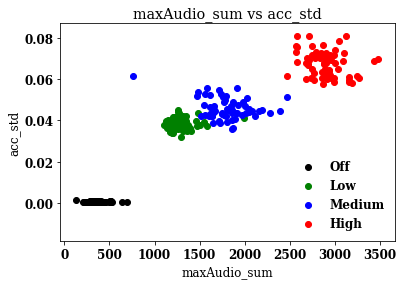

In [27]:
f1=features.columns[indices[0]]
f2=features.columns[indices[2]]
    myScatterPandas(features, f1, f2, results)

# Human in the loop
Looking at your data can violate VC Dimension constraints, but once an algorithm is embedded, it's easy to test on new data.  Here we look at one feature at a time vs class membership.  Note that this produces a plot for every feature in the original data set, so it takes a little while for the next cell to complete.

In [28]:
#XXX Uncomment to stop Here for full runs

C:\SPB_Data\.conda\envs\sensmach\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


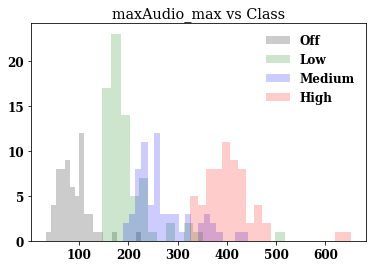

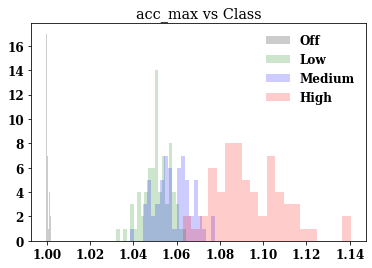

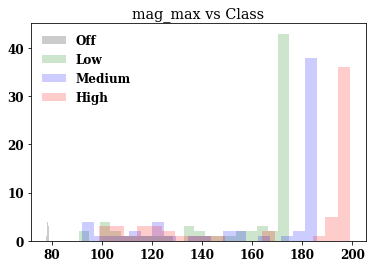

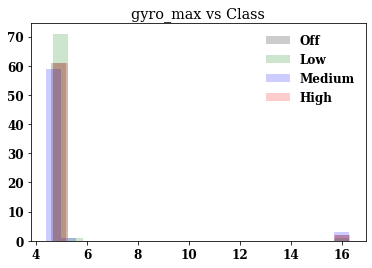

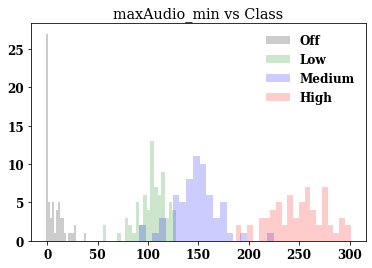

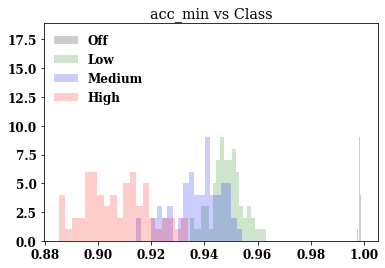

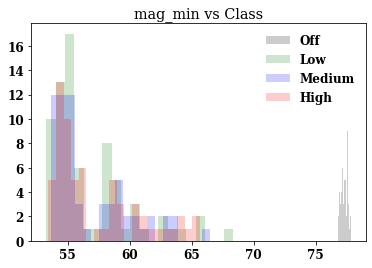

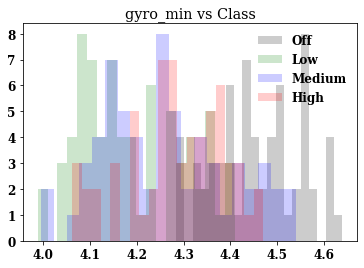

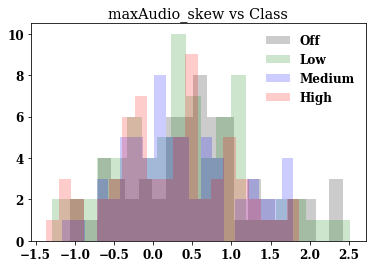

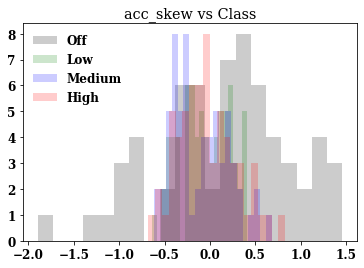

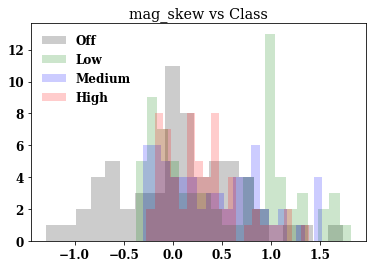

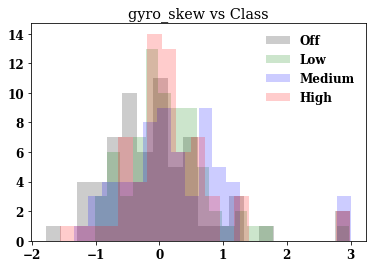

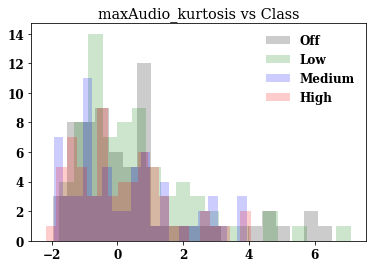

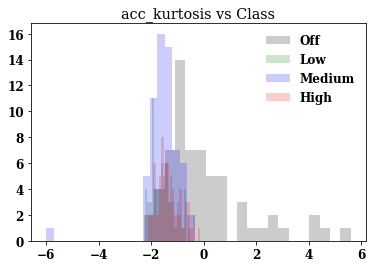

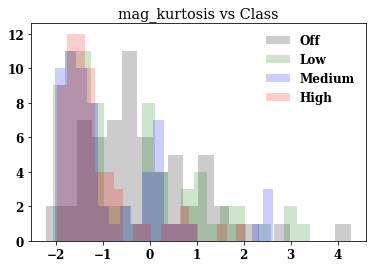

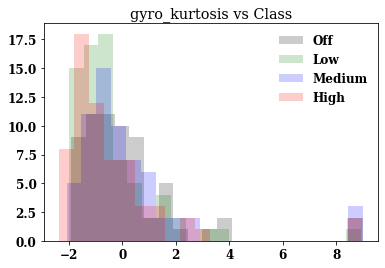

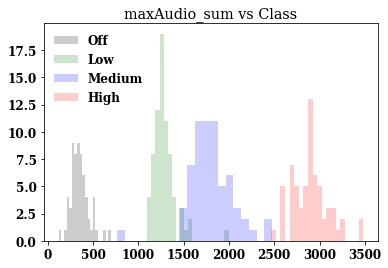

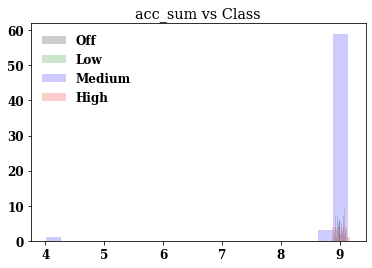

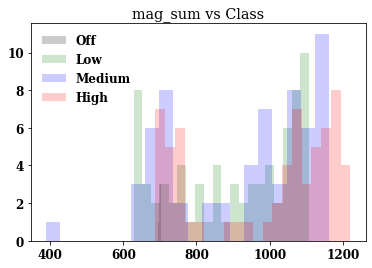

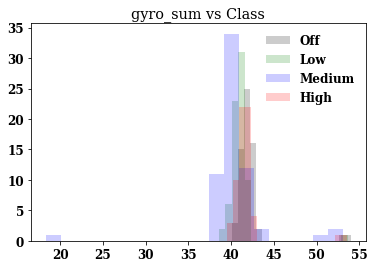

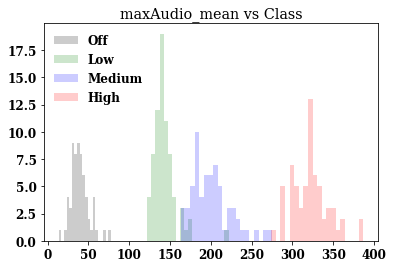

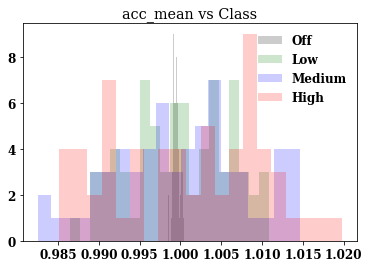

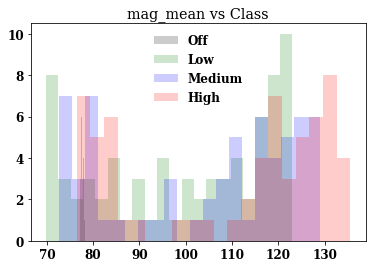

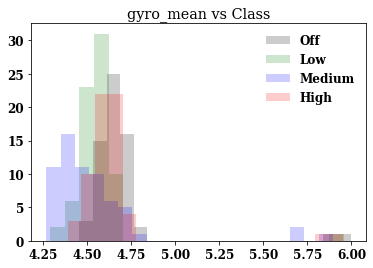

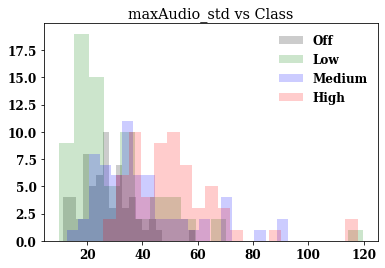

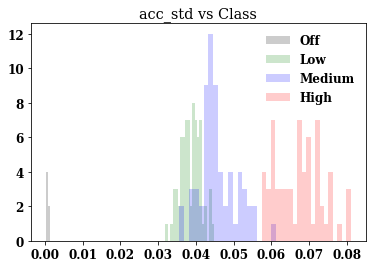

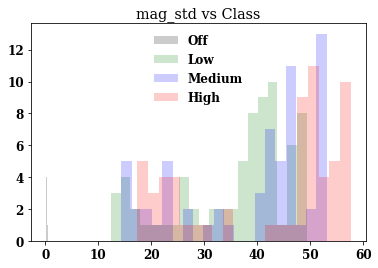

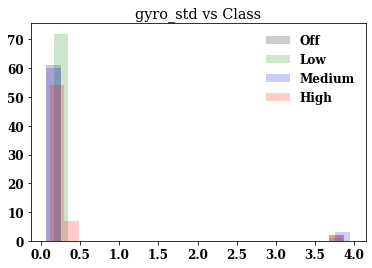

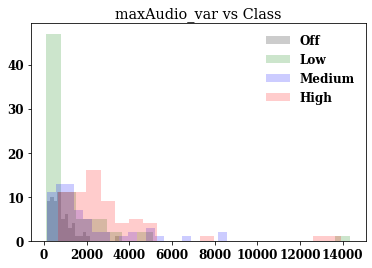

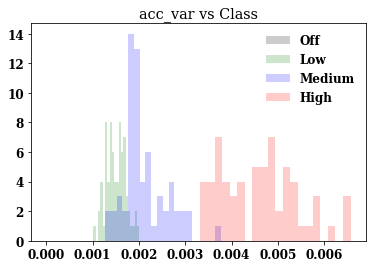

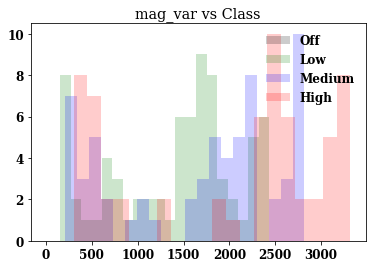

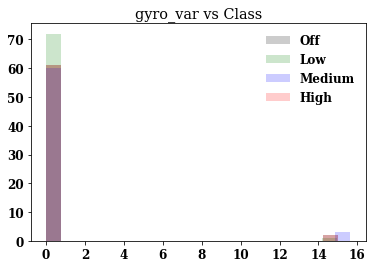

In [30]:
labels=['Off', 'Low', 'Medium', 'High']
color = ['black', 'green', 'blue', 'red']
rows, numFeatures = features.shape
x1 = results.to_numpy()
for i in range(numFeatures):
    fig, ax = plt.subplots()
    for g in np.unique(results):
        ix = np.where(results==g)
        x0 = features.iloc[:,i].to_numpy()
        c=color[g]
        #ax.scatter(x0[ix], x1[ix], c=c, label=labels[g])
        ax.hist(x0[ix], bins=20, color=c, label=labels[g], alpha=.2)
        plt.title(features.columns[i]+' vs Class')
        plt.legend(loc='best', frameon=False, labels=['Off', 'Low', 'Medium', 'High'])

Eyeballing the histograms above, you can see why 
* f1 = 'maxAudio_sum'
* f2 = 'acc_std'

predicted via the Forest of Trees Importance methodology should yield reasonable results.
Ideally, we would like a bit more separation between the 'Low' and 'Medium' classes.  We can predict a bit of error between those two classes when we finally look at a confusion matrix and run our fielded model.  

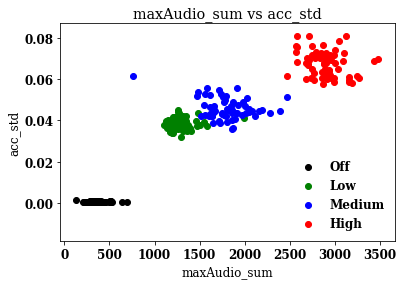

In [31]:
myScatterPandas(features, 'maxAudio_sum', 'acc_std', results)